In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *  
from radiative import *
from utils import *
from plot_utils import nice_fonts

[]

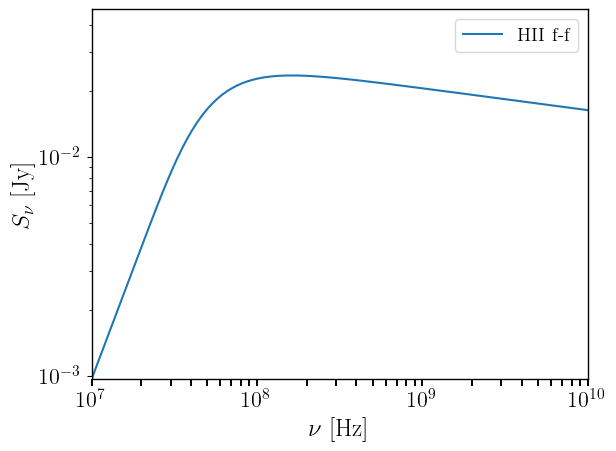

In [2]:
# Simple check of the S_ff function:
R_s = 1e17
D = 1e21
T_e = 1e4
n = 1e3
nu = np.geomspace( 1e7, 1e10, 100)
S = S_ff(nu=nu, R=R_s, D=D, Te=T_e, n=n)

# Plot data and fit
fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.plot(nu, S, label = 'HII f-f')
plt.title('')
plt.xlim(nu[0], nu[-1])
plt.ylim(min(S), 2.0*max(S))

plt.legend(loc='best')
ax.loglog()

## Model for a random system

In [4]:
# System parameters
D = 2.0 * kpc
T_e = 1e4
theta_s = 30.0 #arcsec
R_s = theta_s * (D/pc) * au  # R_s[AU] = theta_s[arcsec] * D[pc]

# Observations to fit
nu = np.array( [325e6, 735e6, 1260e6, 4.8e9, 8.4e9] ) # in Hz
S = np.array( [1.6, 3.3, 4.0, 3.9, 3.5] )      # in Jy
S_err = np.array( [0.1*flux for flux in S] ) # assume a 10% calibration error

In [5]:
# Model fitting

# Define seed values for the fit
seed = np.array([2]) # log(n)
bs = ((1), (5)) # ( min values, max values ) = ( (min_n, ...), (max_n, ...) )

# Fit function S_ff(nu, R, D, Te, n) to the data  
popt, pcov = curve_fit( lambda x, logn: S_ff(x,R_s,D,T_e,10**logn), xdata=nu, ydata=S, p0=seed, sigma=S_err, bounds=bs, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
    
n = ufloat(10**popt[0], 10**popt[0] * perr[0]) # I fit log(n), so the error delta(logn) = (delta n)/n

print(f'Density: {n = :.2u}')

# prepare confidence level curves
nstd = 1.0 # to draw 1-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

nu_fit = np.geomspace( min(nu)/1.5, max(nu)*5., 100)
fit = S_ff(nu_fit, R_s,D,T_e, n.nominal_value)
fit_up = S_ff(nu_fit, R_s,D,T_e, 10**popt_up[0])
fit_dw = S_ff(nu_fit, R_s,D,T_e, 10**popt_dw[0])


Density: n = 3283+/-38


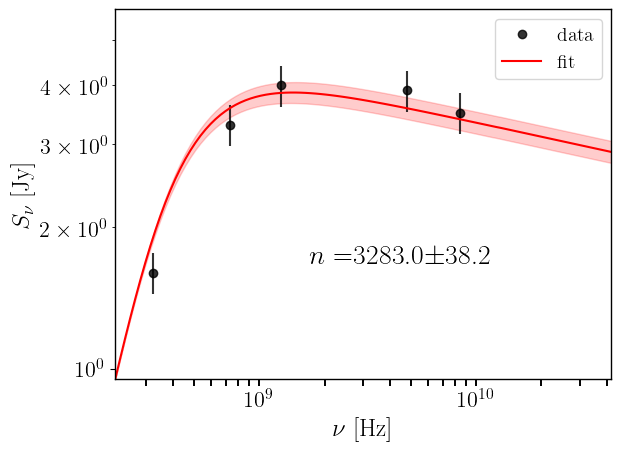

In [6]:
# Plot data and fit

fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.errorbar(nu, S, yerr=S_err, ecolor='k', alpha=0.8, fmt='none')
plt.plot(nu, S, 'ko', alpha=0.8, label = 'data')
plt.plot(nu_fit, fit, 'r-', label='fit')
ax.fill_between(nu_fit, fit_up, fit_dw, alpha=.2, label='', color='r')
plt.title('')
plt.xlim(nu_fit[0], nu_fit[-1])
plt.ylim(min(fit), 1.5*max(fit))

plt.legend(loc='best')
ax.loglog()
ax.annotate(r'$n =$' + str(round(abs(n.nominal_value),1)) + '$\pm$' + str(round(n.std_dev,1)),
            xy=(0.35, 0.25), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

plt.show()

In [7]:
# Simple check of the S_ff function:
R_s = 1e17
D = 1e21
T_e = 1e4
ns = np.geomspace( 1e3, 1e4, 6)
nu = np.geomspace( 1e8, 1e11, 100)
Ss = []
for n in ns:
    S = S_ff(nu, R_s, D, T_e, n)
    Ss.append(S) 

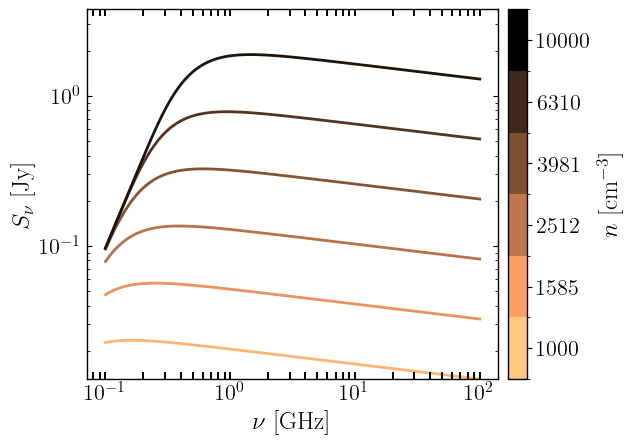

In [8]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title('')
plt.gca().set_xlabel(r'$\nu$ [GHz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
ymin, ymax = min(Ss[0]), 2*max(Ss[-1])  # For fluxes
#plt.xlim(nu_min/1e9, nu_max/1e9)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
m = len(Ss)
color_vector = np.linspace(0.1,0.9,m)
colors = plt.cm.copper_r(color_vector) 

# Generate a discrete colorbar for "n" points
co = np.arange(1, m+1) 
cmap = matplotlib.colormaps['copper_r'].resampled(m)
norm = matplotlib.colors.BoundaryNorm(np.arange(m+1)+0.5,m)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of M
for i in range(m):
    plt.plot(nu/1e9, Ss[i], ls='-', color=colors[i], linewidth=2, label='', zorder=1)

ax.loglog() 
#ax.xaxis.labelpad = -8

cbar = fig.colorbar(sm, ticks=co, label=r"$n$ [cm$^{-3}$]", pad=0.02, ax=plt.gca())
ns_labels = ['{:.0f}'.format(n/1e0) for n in ns]
cbar.ax.set_yticklabels(ns_labels)  # vertically oriented colorbar
ax.tick_params(axis="both", which="both", right=True, left=True, top=True, direction="in")

plt.show()
#fig.savefig('corona_seds_M.pdf', bbox_inches='tight', pad_inches = 0.01)

In [9]:
h = 6.6260755e-27
k_B = 1.380658e-16

# Simple check of the S_ff function:
R_s = 1e17
D = 1e21
n = 1e3
Ts = np.geomspace(1e2, 1e4, 3)
nu = np.geomspace( 1e8, 5e10, 200 )
Ss = []
for T in Ts:
    S_Jy = S_ff(nu, R_s, D, T, n) 
    nu_c = k_B * T / h 
    print(f'{nu_c/1e9 = }')
    S = [1e3*x * np.exp(-nu_i/nu_c) for (x,nu_i) in zip(S_Jy,nu)]         
#    exp_term = [np.exp(nu_i/nu_c) -1. for nu_i in nu]
#    factor = [min(1, x) for x in exp_term]
#    print(factor)
#    S = [1e3 * x / f for (x,f) in zip(S_Jy,factor)] 

    Ss.append(S) 

nu_c/1e9 = 2083.6738126512446
nu_c/1e9 = 20836.738126512446
nu_c/1e9 = 208367.38126512445


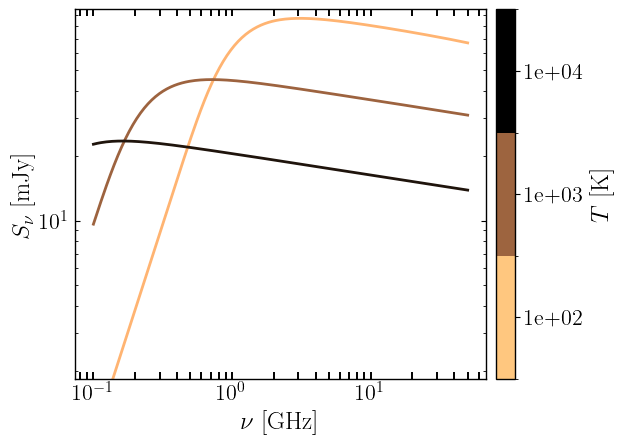

In [10]:
fig, ax = plt.subplots()

# Set labels and limits
plt.title('')
plt.gca().set_xlabel(r'$\nu$ [GHz]')
plt.gca().set_ylabel(r'$S_\nu$ [mJy]')
ymin, ymax = 1.9*min(Ss[0]), 1.1*max(Ss[0])  # For fluxes
#plt.xlim(0.1, 5e4)
plt.ylim(ymin, ymax)

# Define a discrete palette avoiding extreme colors
m = len(Ts)
color_vector = np.linspace(0.1,0.9,m)
colors = plt.cm.copper_r(color_vector) 

# Generate a discrete colorbar for "n" points
co = np.arange(1, m+1) 
cmap = matplotlib.colormaps['copper_r'].resampled(m)
norm = matplotlib.colors.BoundaryNorm(np.arange(m+1)+0.5,m)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot for each value of M
for i in range(m):
    plt.plot(nu/1e9, Ss[i], ls='-', color=colors[i], linewidth=2, label='', zorder=1)

ax.loglog() 
#ax.xaxis.labelpad = -8

cbar = fig.colorbar(sm, ticks=co, label=r"$T$ [K]", pad=0.02, ax=plt.gca())
Ts_labels = ['{:.0e}'.format(T/1e0) for T in Ts]
cbar.ax.set_yticklabels(Ts_labels)  # vertically oriented colorbar
ax.tick_params(axis="both", which="both", right=True, left=True, top=True, direction="in")

plt.show()
#fig.savefig('corona_seds_M.pdf', bbox_inches='tight', pad_inches = 0.01)